<center><h1>Predicting the Online Shopping Purchase Intention</h1></center>
<center><h3>Appendix: code for the models</h3></center>

<div style="text-align: right;">
    Ana Leopold, s1093729<br>
    Luca Maas, s1096050<br>
    22 December 2023
</div>

# Data

In [1]:
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Loading the data
data = pd.read_csv('online_shoppers_intention.csv')

# X represents the data, y represents the classes - 0 for false, 1 for true, given the Revenue attribute
X = data.drop('Revenue', axis = 1)
y = data['Revenue'].astype(int) 

attribute_names = ['Administrative', 'Administrative duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month', 'OperatingSystem', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

#Preproccesing:

# Mapping the attribute Month to numerical values 0-11
month_mapping = {'Jan': 0, 'Feb': 1, 'Mar': 2, 'Apr': 3, 'May': 4, 'June': 5, 'Jul': 6, 'Aug': 7, 'Sep': 8, 'Oct': 9, 'Nov': 10, 'Dec': 11}
X['Month'] = X['Month'].replace(month_mapping)

# Mapping the attribute VisitorType to numerical values 0 and 1
visitor_mapping = {'New_Visitor': 0, 'Returning_Visitor': 1, 'Other': 2}
X['VisitorType'] = X['VisitorType'].replace(visitor_mapping)

# Mapping the attribute Weekend to numerical values 0 (false) and 1(true)
X['Weekend'] = X['Weekend'].astype(int)

# print(X)
# print(y)


There is 10422 data points where Revenue = False, which is  0.845% of the data


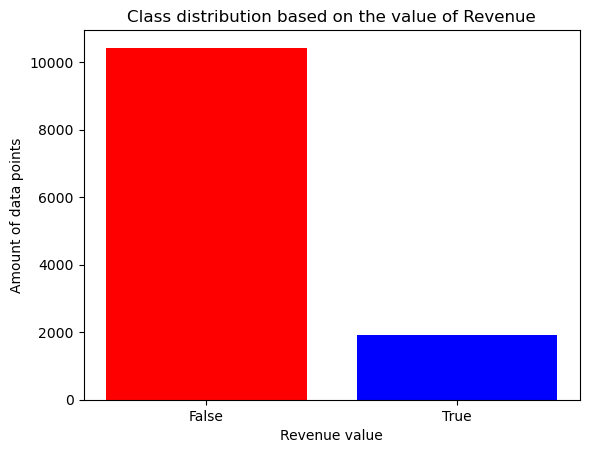

In [3]:
# The data distribution

false_data = data[data['Revenue'] == False].shape[0]
true_data = data[data['Revenue'] == True].shape[0]

labels = ['False', 'True']
amount = [false_data, true_data]

plt.figure()
plt.bar(labels, amount, color = ['red', 'blue'])
plt.title("Class distribution based on the value of Revenue")
plt.xlabel("Revenue value")
plt.ylabel("Amount of data points")



print(f"There is {false_data} data points where Revenue = False, which is {false_data/(false_data + true_data): .3f}% of the data")

There is 6983 data points where Revenue = False, which is 0.5% of the data.
There is 6983 data points where Revenue = True, which is 0.5% of the data.


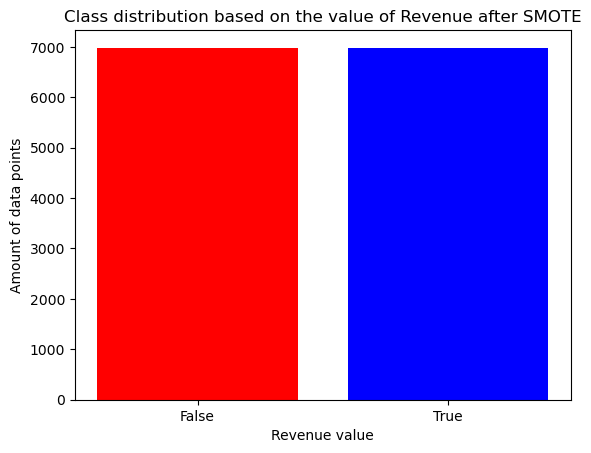

In [4]:
# Preproccesing using SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 1337, stratify = y)
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


false_data = y_train_resampled[y_train_resampled == 0].shape[0]
true_data =  y_train_resampled[ y_train_resampled == 1].shape[0]

labels = ['False', 'True']
amount = [false_data, true_data]

plt.figure()
plt.bar(labels, amount, color = ['red', 'blue'])
plt.title("Class distribution based on the value of Revenue after SMOTE")
plt.xlabel("Revenue value")
plt.ylabel("Amount of data points")

print(f"There is {false_data} data points where Revenue = False, which is {false_data/(false_data + true_data)}% of the data.")
print(f"There is {true_data} data points where Revenue = True, which is {true_data/(false_data + true_data)}% of the data.")

# Decision Tree model

Choosing depth = 6 as optimal.


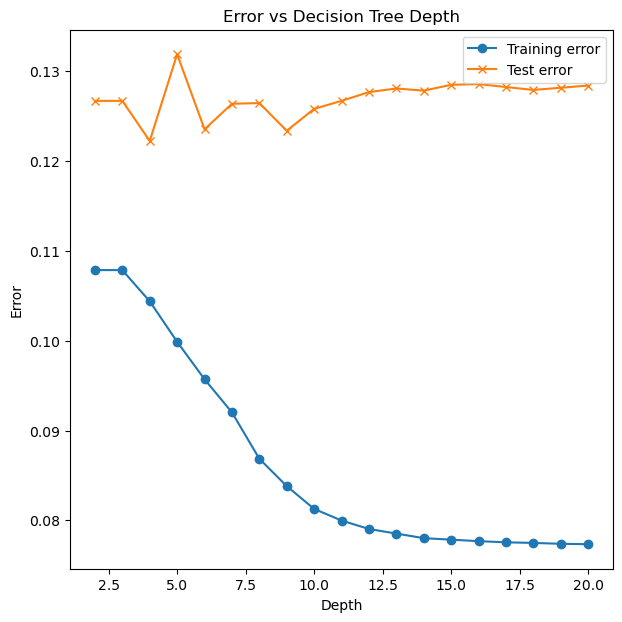

In [5]:
# Feature selection - max_depth
from sklearn import tree
from sklearn.metrics import accuracy_score

# Testing depths 2 - 20
depths = np.arange(2, 21)

skf = StratifiedKFold(n_splits = 10, random_state = 1337, shuffle = True)
smote = SMOTE(random_state=42)

error_train_means = np.empty(19)
error_test_means = np.empty(19)

#Performing 10-Fold cross validation for max_depth 2 - 20
for i, depth in enumerate(depths):
    
    error_train = []
    error_test = []
    
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Using SMOTE on training data only
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        
        # Fitting the Decision Tree classifier
        dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth = depth, min_samples_split = 100).fit(X_train_resampled, y_train_resampled)     
        y_test_pred = dtc.predict(X_test)
        y_train_pred = dtc.predict(X_train_resampled)
        
        # Computing the error of the tree prediction
        training = 1 - accuracy_score(y_train_resampled, y_train_pred)
        testing = 1 - accuracy_score(y_test, y_test_pred)
        
        error_train.append(training)
        error_test.append(testing)   
    
    # Computing the mean of errors for all folds for each depth
    error_train_means[i] = np.mean(error_train)
    error_test_means[i] = np.mean(error_test)

# Plotting the error means vs depth
plt.figure(figsize = (7, 7))
plt.plot(depths, error_train_means,  label = "Training error", marker = 'o')
plt.plot(depths, error_test_means,  label = "Test error", marker = 'x')
plt.xlabel("Depth")
plt.ylabel("Error")
plt.title("Error vs Decision Tree Depth")
plt.legend()     

print("Choosing depth = 6 as optimal.")

The optimal value for min_samples_split is 100.


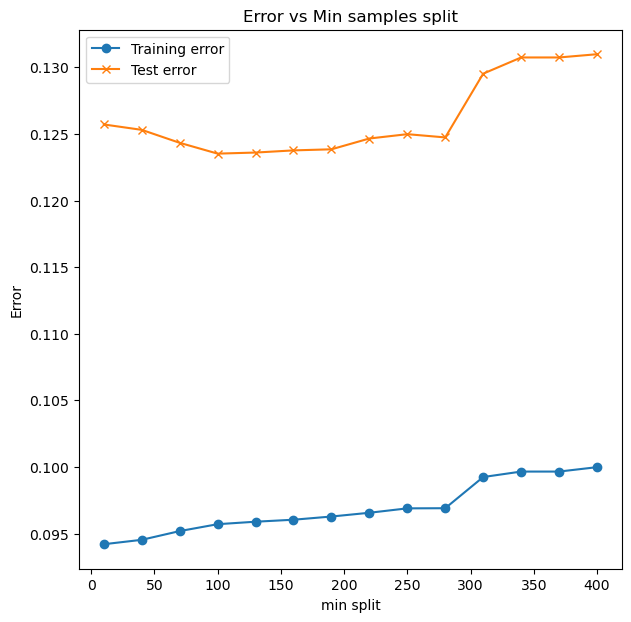

In [6]:
# Feature selection - min_samples_split

# Testing min_samples_split from 10 to 400 in the steps of 30 (10, 40, 70...,400)
min_sample_splits = list(range(10, 401 , 30))

error_train_means = np.empty(14)
error_test_means = np.empty(14)

#Performing 10-Fold cross validation for min_samples_split 2 - 20
for i, split in enumerate(min_sample_splits):    
    error_train = []
    error_test = []
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Using SMOTE on training data only
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        
        # Fitting the Decision Tree classifier
        dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth = 6, min_samples_split = split).fit(X_train_resampled, y_train_resampled)       
        y_test_pred = dtc.predict(X_test)
        y_train_pred = dtc.predict(X_train_resampled)
        
        # Computing the error of the tree prediction
        training = 1 - accuracy_score(y_train_resampled, y_train_pred)
        testing = 1 - accuracy_score(y_test, y_test_pred)
        
        error_train.append(training)
        error_test.append(testing)   
    
    # Computing the error means of all folds for each value of min_sample_split
    error_train_means[i] = np.mean(error_train)
    error_test_means[i] = np.mean(error_test)

# Plotting the error means vs min_samples_split
plt.figure(figsize = (7, 7))
plt.plot(min_sample_splits, error_train_means,  label = "Training error", marker = 'o')
plt.plot(min_sample_splits, error_test_means,  label = "Test error", marker = 'x')
plt.xlabel("min split")
plt.ylabel("Error")
plt.title("Error vs Min samples split")
plt.legend()

print("The optimal value for min_samples_split is 100.")

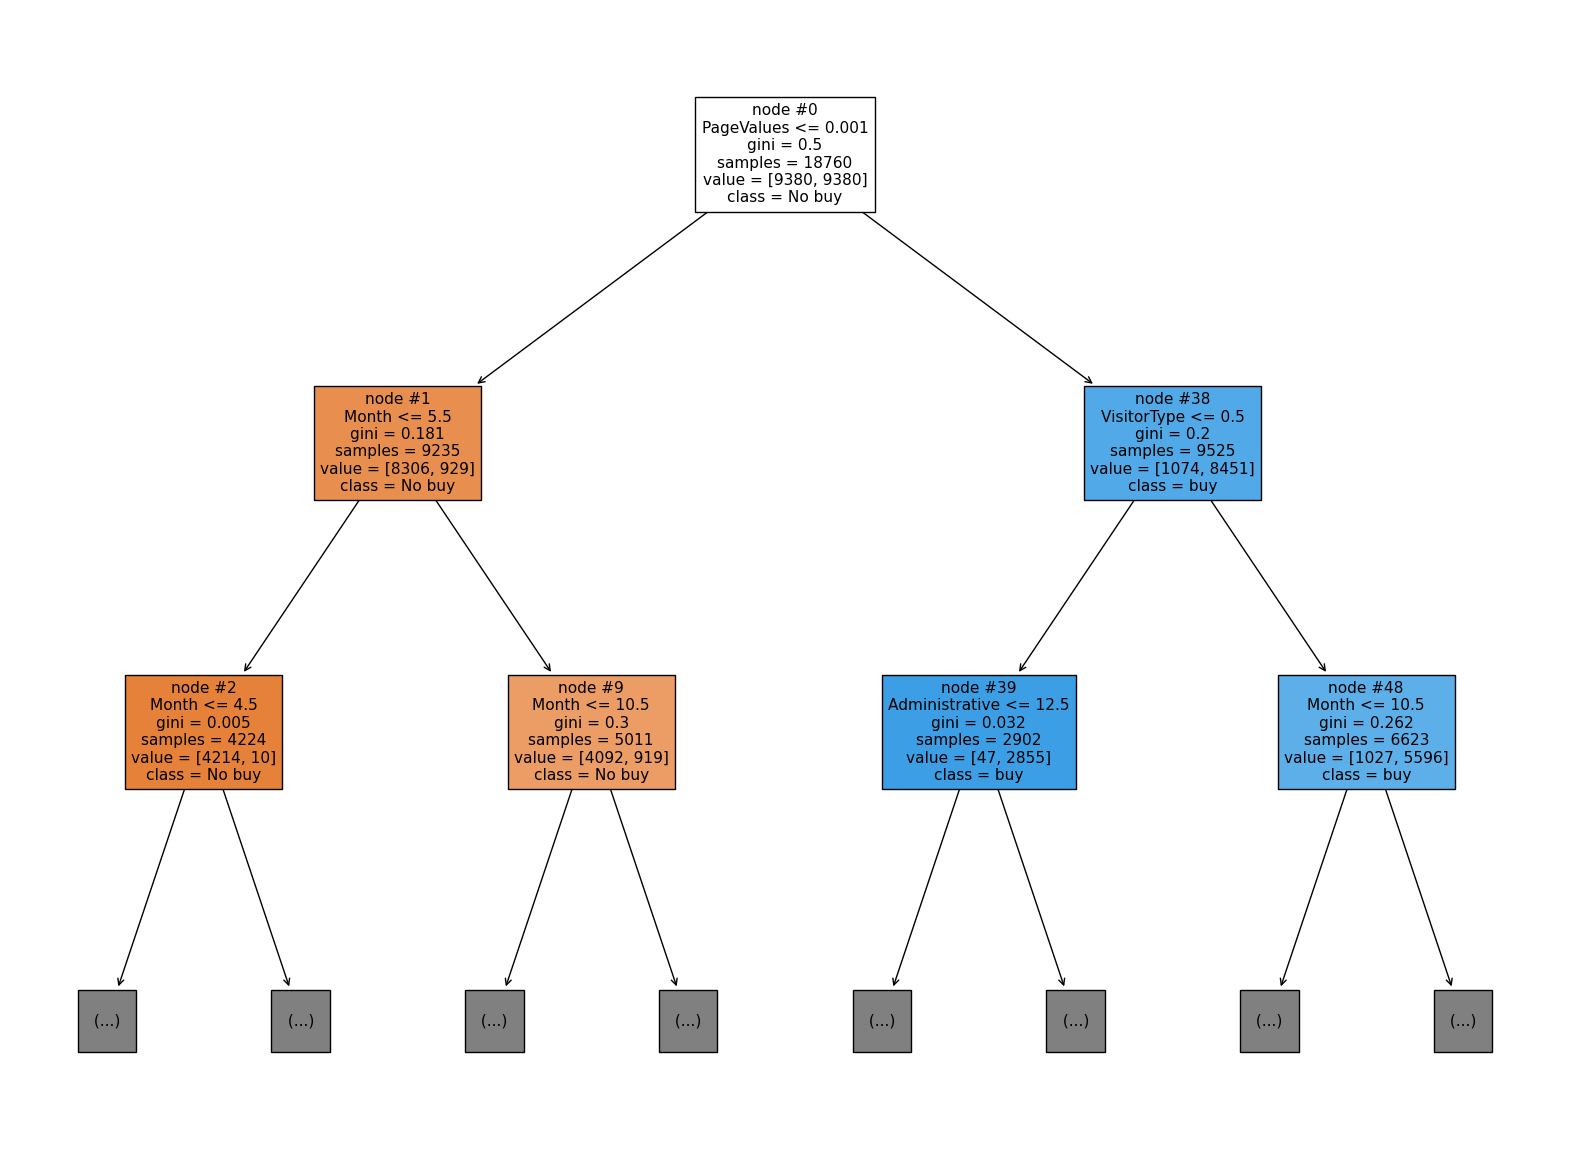

In [7]:
# Making the model with optimal parameters

depth = 6
min_samples_split = 100

# Initalizing the Decision tree
dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth = depth, min_samples_split = min_samples_split)


whole_y_true = []
whole_y_pred = []

whole_y_probs = [] # For computing the ROC and AUC score

# Performing 10-fold cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Smote
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Fitting the tree on resampled data
    dtc.fit(X_train_resampled, y_train_resampled)
    y_pred = dtc.predict(X_test)
    y_probs = dtc.predict_proba(X_test)[:, 1]

    whole_y_true.extend(y_test)
    whole_y_pred.extend(y_pred)
    whole_y_probs.extend(y_probs)
    
# Plotting the tree
plt.figure(figsize = (20,15))
tree.plot_tree(dtc, feature_names = attribute_names,  class_names = ['No buy', 'buy'], filled = True, node_ids = True, max_depth = 2)
plt.show()




Accuracy: 0.8764801297648013
Precision: 0.5748153905946366
Recall score: 0.7751572327044025
F1 score: 0.6601205088149966
Final roc auc score: 0.9159793204747094


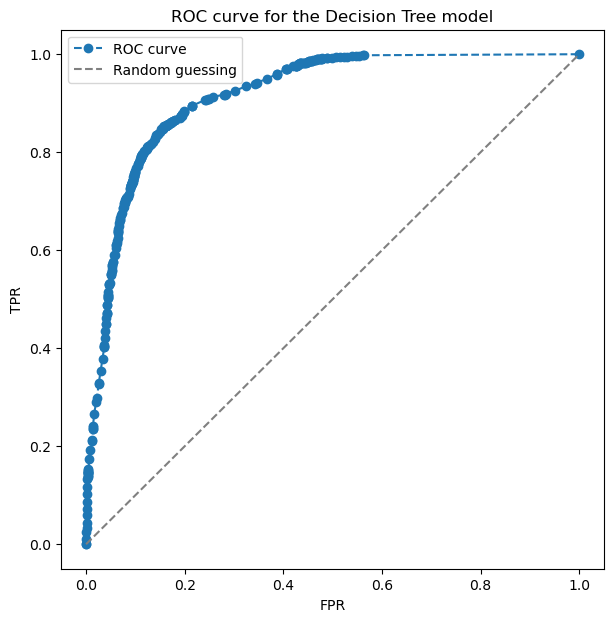

In [8]:
# Evaluation of the Decision Tree model
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Accuracy
accuracy = accuracy_score(whole_y_true, whole_y_pred)
print(F"Accuracy: {accuracy}")

# Precision
precision = precision_score(whole_y_true, whole_y_pred)
print(f"Precision: {precision}")

# Recall
recall = recall_score(whole_y_true, whole_y_pred)
print(f"Recall score: {recall}" )

# F1 score
f1 = f1_score(whole_y_true, whole_y_pred)
print(f"F1 score: {f1}")

# ROC and AUC score
roc_auc = roc_auc_score(whole_y_true, whole_y_probs)
print(f'Final roc auc score: {roc_auc}')  

# Plotting the curve
fpr, tpr, thresholds = roc_curve(whole_y_true, whole_y_probs)

plt.figure(figsize = (7,7))
plt.plot(fpr, tpr, '--o', label = 'ROC curve')
plt.plot([0,1], '--', color = 'gray', label = 'Random guessing')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC curve for the Decision Tree model")
plt.legend()

# K-Nearest Neighbours model

Choosing measure = cosine as optimal.


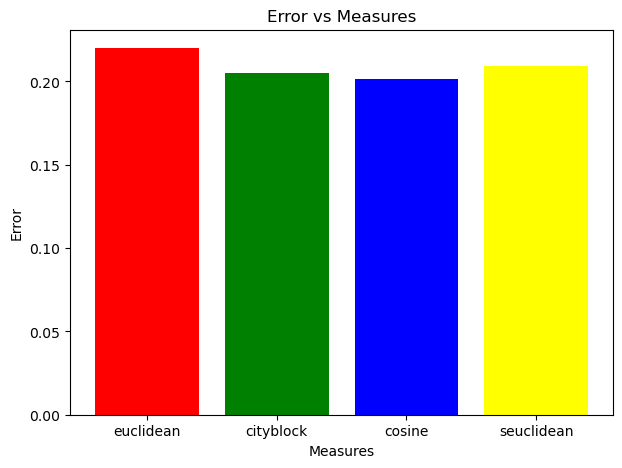

In [9]:
# Feature selection - measure 

from sklearn.neighbors import KNeighborsClassifier

# Testing measures
measures = ['euclidean', 'cityblock', 'cosine', 'seuclidean']

skf = StratifiedKFold(n_splits = 10, random_state = 1337, shuffle = True)
smote = SMOTE(random_state=42)

error_test_means = np.empty(4)

#Performing 10-Fold cross validation for the measures
for i, m in enumerate(measures):

    error_test = []
    
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Using SMOTE on training data only
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        
        # Fitting the KNN classifier
        vector = np.var(X_train_resampled, axis = 0 )     
        cls = KNeighborsClassifier(n_neighbors=3, metric = m, metric_params = {'V':vector} if m == 'seuclidean' else None)
        cls = cls.fit(X_train_resampled, y_train_resampled)
        y_pred = cls.predict(X_test)
       
        # Computing the error of the classifier prediction
        testing = 1 - accuracy_score(y_test, y_pred)
        
        error_test.append(testing)   
    
    # Computing the mean of errors for all folds for each measure
    error_test_means[i] = np.mean(error_test)


# Plotting the error means vs measures
plt.figure(figsize = (7, 5))
plt.bar(measures, error_test_means, color = ['red', 'green', 'blue', 'yellow'])
plt.xlabel("Measures")
plt.ylabel("Error")
plt.title("Error vs Measures")     

print("Choosing measure = cosine as optimal.")

Choosing k = 4 as optimal.


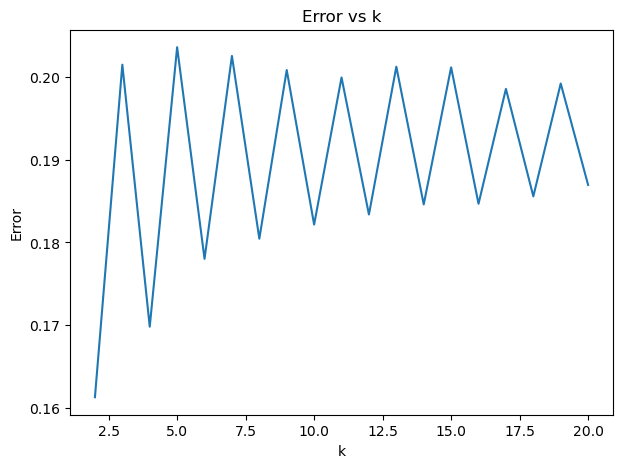

In [10]:
# Feature selection - k

# Testing k 2-20
ks = np.arange(2, 21)

skf = StratifiedKFold(n_splits = 10, random_state = 1337, shuffle = True)
smote = SMOTE(random_state=42)

error_test_means = np.empty(19)

#Performing 10-Fold cross validation for the measures
for k in range(19):
    
    error_train = []
    error_test = []
    
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Using SMOTE on training data only
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        
        # Fitting the KNN classifier
        vector = np.var(X_train_resampled, axis = 0 )     
        cls = KNeighborsClassifier(n_neighbors = k + 2, metric = "cosine")
        cls = cls.fit(X_train_resampled, y_train_resampled)
        y_pred = cls.predict(X_test)
       
        # Computing the error of the classifier prediction
        testing = 1 - accuracy_score(y_test, y_pred)
        
        error_test.append(testing)   
    
    # Computing the mean of errors for all folds for each measure
    error_test_means[k] = np.mean(error_test)


# Plotting the error means vs k
plt.figure(figsize = (7, 5))
plt.plot(ks, error_test_means,  label = "Error")
plt.xlabel("k")
plt.ylabel("Error")
plt.title("Error vs k")     

print("Choosing k = 4 as optimal.")

In [11]:
# Making the model with optimal parameters

measure = 'cosine'
k = 4

# Initalizing the KNN 
cls = KNeighborsClassifier(n_neighbors = k, metric = measure)


whole_y_true = []
whole_y_pred = []

whole_y_probs = [] # For computing the ROC and AUC score

# Performing 10-fold cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Smote
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Fitting the KNN on resampled data
    cls = cls.fit(X_train_resampled, y_train_resampled)
    y_pred = cls.predict(X_test)
    y_probs = cls.predict_proba(X_test)[:, 1]

    whole_y_true.extend(y_test)
    whole_y_pred.extend(y_pred)
    whole_y_probs.extend(y_probs)
    

Accuracy: 0.8301703163017031
Precision: 0.46575846833578793
Recall score: 0.6629979035639413
F1 score: 0.5471453287197232
Roc auc score: 0.8253928202596749


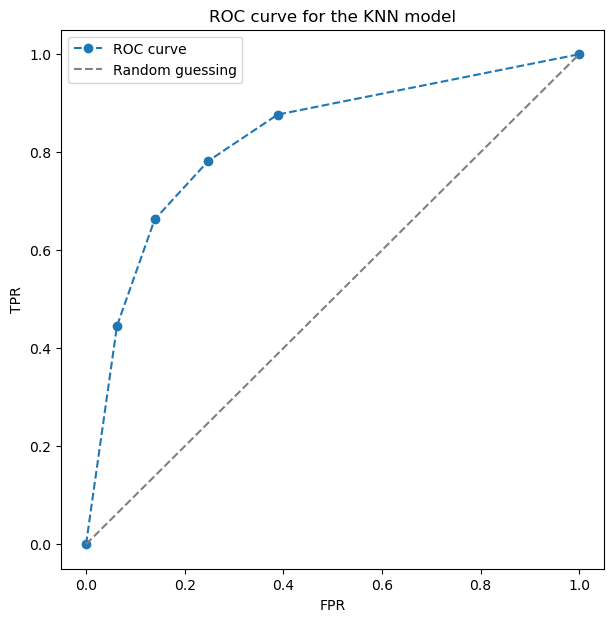

In [14]:
# Evaluation of the KNN

# Accuracy
accuracy = accuracy_score(whole_y_true, whole_y_pred)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(whole_y_true, whole_y_pred)
print("Precision:", precision)

# Recall
recall = recall_score(whole_y_true, whole_y_pred)
print("Recall score:", recall)

# F1 score
f1 = f1_score(whole_y_true, whole_y_pred)
print("F1 score:", f1)

# ROC and AUC score
roc_auc = roc_auc_score(whole_y_true, whole_y_probs)
print(f'Roc auc score: {roc_auc}') 

# Plotting the curve
fpr, tpr, thresholds = roc_curve(whole_y_true, whole_y_probs)

plt.figure(figsize = (7,7))
plt.plot(fpr, tpr, '--o', label = 'ROC curve')
plt.plot([0,1], '--', color = 'gray', label = 'Random guessing')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC curve for the KNN model")
plt.legend()